<a href="https://colab.research.google.com/github/Yogesh7920/Pascal-VOC/blob/main/Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing processed data from Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/dataset/Pascal_VOC/cache/

/content/drive/MyDrive/dataset/Pascal_VOC/cache


# Importing required Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from tqdm import tqdm
from copy import deepcopy
import cv2
import seaborn as sns

#Model Development
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import Loss, BinaryCrossentropy
from keras.utils import plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D, \
                                    BatchNormalization, GlobalAveragePooling2D, Lambda, \
                                    Embedding, GlobalAveragePooling1D, Concatenate, LSTM, \
                                    Bidirectional, Input, Reshape
                                    
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import   VGG19, vgg19, VGG16, vgg16, InceptionV3, inception_v3, \
                                            Xception, xception
from tensorflow.keras.models import Model, load_model
from tensorflow.python.keras.utils.layer_utils import count_params
from tensorflow.keras.callbacks import ReduceLROnPlateau

#sklearn
from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight

There are 20 labels in this problem

In [ ]:
labels = np.array(['person', 'bird', 'cat', 'cow', 'dog', 'horse',
              'sheep', 'aeroplane', 'bicycle', 'boat', 'bus', 'car',
              'motorbike', 'train', 'bottle', 'chair', 'dining table',
              'potted plant', 'sofa', 'tv/monitor'])

Loading the images and targets

In [ ]:
get_resized_images = False

In [ ]:
if get_resized_images:
    abstract_images = np.load('abstract_images_resized.npy', allow_pickle=True)
else:
    abstract_images = np.load('abstract_images.npy', allow_pickle=True) * 255
abstract_images = abstract_images[:, :, :, :3]

if get_resized_images:
    pascal_images = np.load('pascal_images_resized.npy', allow_pickle=True)
else:
    pascal_images = np.load('pascal_images.npy', allow_pickle=True)

abstract_targets = np.load('abstract_targets.npy', allow_pickle=True)
pascal_targets = np.load('pascal_targets.npy', allow_pickle=True)

A sample from Abstract50s dataset.

array(['person', 'cat'], dtype='<U12')

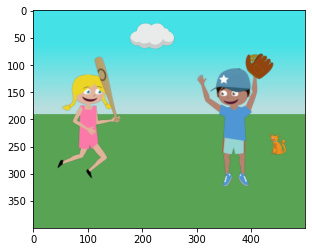

In [ ]:
index = 0
if get_resized_images:
  plt.imshow(abstract_images[index]/255)
else:
  plt.imshow(abstract_images[index].astype(int))
labels[abstract_targets[index] == 1]

A sample from Pascal50s dataset

array(['dog'], dtype='<U12')

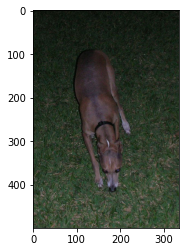

In [ ]:
index = 11
if get_resized_images:
  plt.imshow(pascal_images[index]/255)
else:
  plt.imshow(pascal_images[index])
labels[pascal_targets[index] == 1]

Resizing

In [ ]:
def resizing(images):
  temp = []
  for image in images:
    resized = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
    temp.append(resized)

  images = np.array(temp)
  return images

In [ ]:
if not get_resized_images:
  abstract_images = resizing(abstract_images)
  pascal_images = resizing(pascal_images)

Normalization. 

*Note: Abstract50s is normalized by default*

In [ ]:
normailize = False

In [ ]:
if normailize and np.max(abstract_images) == 255:
  abstract_images = abstract_images / 255

if normailize and np.max(pascal_images) == 255:
  pascal_images = pascal_images / 255

Combining the two datasets

In [ ]:
images = np.concatenate((pascal_images, abstract_images), axis=0)
images = np.round(images)

In [ ]:
targets = np.concatenate((pascal_targets, abstract_targets), axis=0)

We split or dataset into train and test

*Note: the dataset is also shuffled in this process*

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(images, targets, test_size=0.2, shuffle=True, random_state=42)

**Class Weights**


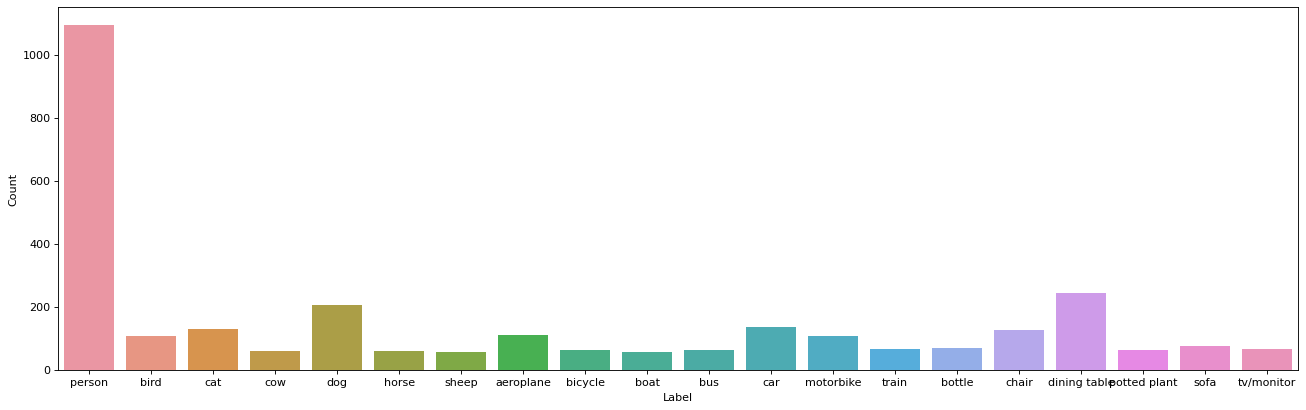

In [ ]:
class_weights = np.sum(targets, axis=0)
df = pd.DataFrame({
    'Label': labels,
    'Count': class_weights
})
plt.figure(figsize=(20, 6), dpi=80)
sns.barplot(x='Label', y='Count', data=df)

# Model

F1-score Loss function

In [ ]:
@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1
    macro_cost = tf.reduce_mean(cost)
    return macro_cost

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

Custom Model

In [ ]:
def get_model():
  model = keras.models.Sequential()
  model.add(layers.Conv2D(input_shape=(images.shape[1],images.shape[2],3),filters=128,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=128, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2)))

  model.add(layers.Conv2D(filters=64, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=64, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.MaxPool2D(pool_size=(2,2),strides=(2,2), name='MP_2'))

  model.add(layers.Conv2D(filters=32, kernel_size=(2,2), padding="same", activation="relu"))
  model.add(layers.BatchNormalization())

  model.add(layers.Conv2D(filters=32, kernel_size=(2,2), padding="same", activation="relu", name='last_conv'))
  model.add(layers.BatchNormalization())
  headModel = model.output
  headModel = layers.Flatten()(headModel)
  headModel = layers.Dropout(rate=0.1)(headModel)

  headModel = layers.Dense(64, activation='relu')(headModel)
  headModel = layers.Dense(64, activation='relu')(headModel)
  headModel = layers.Dense(len(labels), activation='sigmoid')(headModel)
  model = keras.models.Model(inputs=model.input, outputs=headModel)
  # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  model.compile(optimizer='adam', loss=macro_soft_f1, metrics=[macro_f1])
  return model

### Using Pre-trained Models





In [ ]:
def get_cnn_model(pre_trained, shape=(224, 224, 3), allow_train_from=None):
    if allow_train_from is not None:
        """Fine tune the pretrained model if needed."""
        layer_names = [layer.name for layer in pre_trained.layers]
        idx = layer_names.index(allow_train_from)
        for (i, layer) in enumerate(pre_trained.layers[:idx]):
            pre_trained.layers[i].trainable = False
    else:
        pre_trained.trainable = False
    return Model(inputs=pre_trained.input, outputs=pre_trained.output)

In [ ]:
def get_pretrain(name='inception', train=False):
  
  if name == 'inception':
    base_model = InceptionV3(include_top = False, input_shape=(images.shape[1],images.shape[2], 3), weights = 'imagenet', pooling='avg')
    input_preprocessor = inception_v3.preprocess_input
  else:
    base_model = VGG16(input_shape=(images.shape[1],images.shape[2], 3), include_top = False, weights = 'imagenet')
    input_preprocessor = vgg16.preprocess_input
  if not train:
    base_model.trainable = False
  cnn = get_cnn_model(base_model)
  # x = layers.Conv2D(1, (1, 1), name='last_conv')(cnn.output)
  # x = layers.Flatten()(x)
  x = layers.Flatten()(cnn.output)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dense(512, activation='relu')(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(len(labels), activation='sigmoid')(x)

  model = keras.models.Model(cnn.input, x)

  # model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics = ['acc'])
  model.compile(optimizer='adam', loss=macro_soft_f1, metrics=[macro_f1])
  return model, input_preprocessor


In [ ]:
# model = get_model()
model, preprocessor = get_pretrain('inception')

87916544/87910968 [==============================] - 3s 0us/step


In [ ]:
X_train = preprocessor(X_train)
X_test = preprocessor(X_test)
processed_images = preprocessor(deepcopy(images))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
____________________________________________________________________________________________

We will use the follow two callbacks
- Early Stopping - To prevent overfitting
- Model Checkpoint - To save our model's training progress.

In [ ]:
es = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
cp = keras.callbacks.ModelCheckpoint('task1.h5', save_best_only=True)

### The training begins !

Note: the class_weights arugment is passed to acknowlegde the imbalanced dataset

In [ ]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=32, callbacks=[es, cp])

Epoch 1/50
38/38 [==============================] - 49s 328ms/step - loss: 0.8024 - macro_f1: 0.2150 - val_loss: 0.6849 - val_macro_f1: 0.3124
Epoch 2/50
38/38 [==============================] - 8s 209ms/step - loss: 0.6640 - macro_f1: 0.3389 - val_loss: 0.6170 - val_macro_f1: 0.3758
Epoch 3/50
38/38 [==============================] - 8s 209ms/step - loss: 0.5399 - macro_f1: 0.4662 - val_loss: 0.5943 - val_macro_f1: 0.3966
Epoch 4/50
38/38 [==============================] - 8s 211ms/step - loss: 0.5377 - macro_f1: 0.4722 - val_loss: 0.5801 - val_macro_f1: 0.4187
Epoch 5/50
38/38 [==============================] - 8s 210ms/step - loss: 0.5031 - macro_f1: 0.5028 - val_loss: 0.5895 - val_macro_f1: 0.3933
Epoch 6/50
38/38 [==============================] - 8s 212ms/step - loss: 0.4841 - macro_f1: 0.5212 - val_loss: 0.5785 - val_macro_f1: 0.4158
Epoch 7/50
38/38 [==============================] - 8s 212ms/step - loss: 0.4400 - macro_f1: 0.5611 - val_loss: 0.5702 - val_macro_f1: 0.4192
Epoch

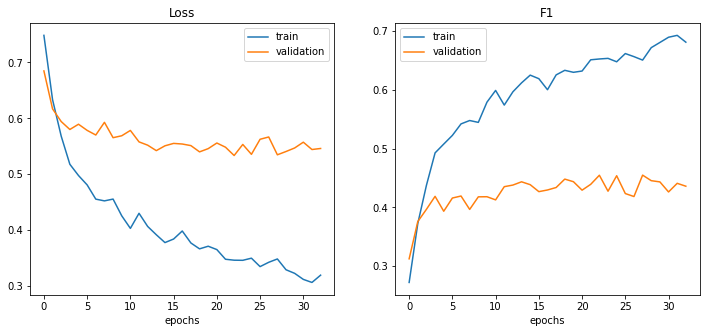

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
epochs = len(history['loss'])
ax[0].plot(range(epochs), history['loss'], label='train')
ax[0].plot(range(epochs), history['val_loss'], label='validation')
ax[1].plot(range(epochs), history['macro_f1'], label='train')
ax[1].plot(range(epochs), history['val_macro_f1'], label='validation')
ax[0].set_title('Loss')
ax[0].set_xlabel('epochs')
ax[0].legend()
ax[1].set_title('F1')
ax[1].set_xlabel('epochs')
ax[1].legend()

# Evaluation

In [ ]:
model.evaluate(X_test, y_test)

10/10 [==============================] - 2s 162ms/step - loss: 0.5335 - macro_f1: 0.4545


[0.5335005521774292, 0.4545362591743469]

In [ ]:
total_preds = (model.predict(processed_images) > 0.5) * 1
test_preds = (model.predict(X_test) > 0.5) * 1

## F1 score

This is a better metrics of measurement as the dataset is imbalanced

In [ ]:
print(classification_report(test_preds, y_test))

              precision    recall  f1-score   support

           0       1.00      0.77      0.87       300
           1       0.29      0.60      0.39        10
           2       0.48      0.48      0.48        21
           3       0.83      0.83      0.83        12
           4       0.17      0.36      0.24        22
           5       0.88      1.00      0.93         7
           6       0.77      0.83      0.80        12
           7       0.42      0.85      0.56        13
           8       0.92      0.67      0.77        18
           9       0.80      0.67      0.73        12
          10       0.73      0.55      0.63        20
          11       0.65      0.69      0.67        29
          12       0.85      0.85      0.85        20
          13       0.64      0.70      0.67        10
          14       0.33      0.29      0.31        14
          15       0.54      0.65      0.59        23
          16       0.50      0.42      0.46        52
          17       0.38    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(classification_report(total_preds, targets))

              precision    recall  f1-score   support

           0       1.00      0.73      0.84      1500
           1       0.56      0.87      0.68        69
           2       0.53      0.77      0.63        88
           3       0.88      0.95      0.91        55
           4       0.41      0.63      0.50       133
           5       0.87      1.00      0.93        52
           6       0.93      0.91      0.92        58
           7       0.72      0.90      0.80        89
           8       0.95      0.80      0.87        74
           9       0.93      0.93      0.93        58
          10       0.89      0.75      0.81        75
          11       0.71      0.72      0.71       134
          12       0.93      0.97      0.95       103
          13       0.86      0.85      0.85        66
          14       0.62      0.58      0.60        73
          15       0.76      0.70      0.73       135
          16       0.70      0.58      0.64       295
          17       0.69    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Some Predictions

In [ ]:
def show_labels(target):
  d = dict(zip(labels, target))
  s = {k for k in d if d[k]==1}
  return ', '.join(list(s))

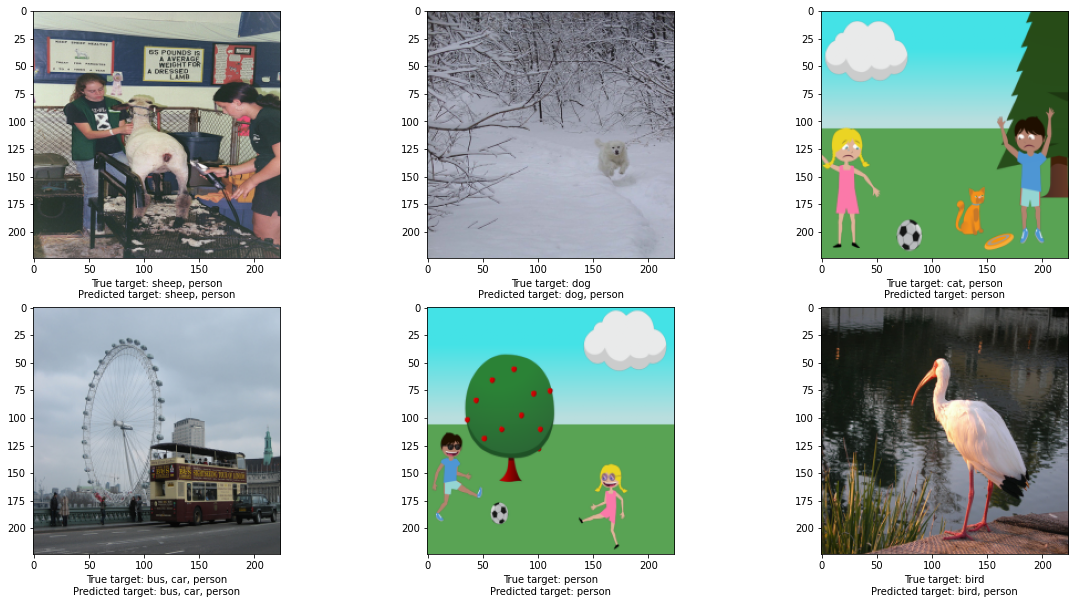

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i in range(2):
  for j in range(3):
    index = np.random.randint(0, 1500)
    image = images[index]
    target = targets[index]
    pred = total_preds[index]
    ax[i][j].set_xlabel("True target: " + show_labels(target) + "\n" + "Predicted target: " + show_labels(pred))
    ax[i][j].imshow(image/255)

# Activation Map

In [ ]:
loaded_model = keras.models.load_model('task1.h5', compile=False)

In [ ]:
"""
Reference: https://keras.io/examples/vision/grad_cam/
The code has been change to suit the requirements of this assignment.
"""


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """First, we create a model that maps the input image to the activations
    of the last conv layer as well as the output predictions."""
    grad_model = tf.keras.models.Model(
        [model.inputs], [last_conv_layer_name.output, model.output]
    )

    """Then, we compute the gradient of the top predicted class for our input image
    with respect to the activations of the last conv layer"""
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    """This is the gradient of the output neuron (top predicted or chosen)
    with regard to the output feature map of the last conv layer"""
    grads = tape.gradient(class_channel, last_conv_layer_output)

    """This is a vector where each entry is the mean intensity of the gradient
    over a specific feature map channel"""
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    """We multiply each channel in the feature map array
    by "how important this channel is" with regard to the top predicted class
    then sum all the channels to obtain the heatmap class activation"""
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    """For visualization purpose, we will also normalize the heatmap between 0 & 1"""
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img, heatmap, ax, alpha=0.4):

    """Rescale heatmap to a range 0-255"""
    heatmap = np.uint8(255 * heatmap)

    """Use jet colormap to colorize heatmap"""
    jet = cm.get_cmap("jet")

    """Use RGB values of the colormap"""
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    """Create an image with RGB colorized heatmap"""
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    """Superimpose the heatmap on original image"""
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    ax.imshow(superimposed_img)

In [ ]:
loaded_model.layers[-1].activation = None

Targets =  {'person'}


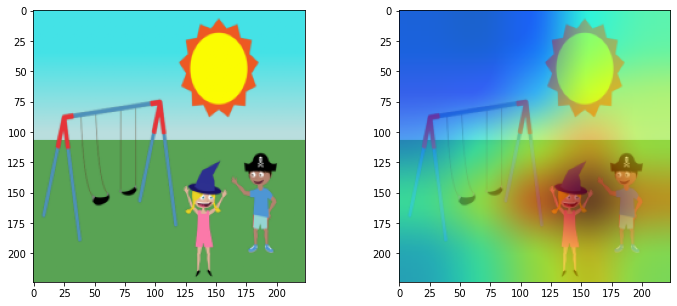

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
index = np.random.randint(0, 1500)
image = images[index]
ax[0].imshow(image/255)

d = dict(zip(labels, targets[index]))
s = {k for k in d if d[k]==1}
print('Targets = ', s)


processed_image = processed_images[index]
x = processed_image
x_= x.reshape(1, 224, 224, 3)
display_gradcam(x, make_gradcam_heatmap(x_, loaded_model, loaded_model.get_layer('mixed10')), ax[1], alpha=1e-2)